[Github链接](http://https://github.com/0HaNC/BIT_DataMining)

# 一、Consumer & Visitor Insights For Neighborhoods 数据集

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
csv = pd.read_csv('/kaggle/input/visit-patterns-by-census-block-group/cbg_patterns.csv')
#人工判断属性类别
nominal = ['census_block_group', 'visitor_home_cbgs', 'visitor_work_cbgs', 'related_same_day_brand', 'related_same_month_brand','top_brands', 'popularity_by_hour', 'popularity_by_day']
numeric = ['date_range_start', 'date_range_end',  'raw_visit_count', 'raw_visitor_count', 'distance_from_home']
assert len(csv.columns)==len(nominal)+len(numeric), f'{len(csv.columns)}!={len(nominal)+len(numeric)}'


# 1. 数据可视化和摘要
## 1.1 数据摘要
* 标称数据

In [13]:
attr = 'top_brands' #设置展示的属性
column = csv[attr]
print(f'属性{attr}可能取值的频数:')
column.value_counts()

属性top_brands可能取值的频数:


[]                                                                                                                                      74540
["United States Postal Service (USPS)"]                                                                                                  5352
["Aflac (American Family Life Assurance)"]                                                                                               1517
["Dollar General"]                                                                                                                       1308
["National Association for the Education of Young Children (NAEYC)"]                                                                     1071
                                                                                                                                        ...  
["Dollar Tree","Cricket Wireless","O'Reilly Auto Parts"]                                                                                    1
["Suno

Text(0.5, 1.0, 'top10 values')

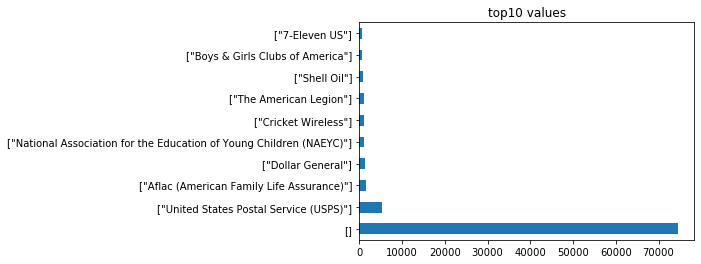

In [14]:
#取前10高频数的取值展示为条形图
ax = column.value_counts().head(10).plot.barh()
plt.title('top10 values')

* 数值数据

In [15]:
column = csv[numeric]
print(f'数值属性的五数概括:')
column.describe()[-5:]

数值属性的五数概括:


,date_range_start,date_range_end,raw_visit_count,raw_visitor_count,distance_from_home
min,1.538352e+09,1.541030e+09,60.0,50.0,706.00
25%,1.538352e+09,1.541030e+09,17042.0,3430.0,8584.00
50%,1.538352e+09,1.541030e+09,30640.0,6541.0,14614.00
75%,1.538352e+09,1.541030e+09,56678.0,13099.0,31397.75
max,1.538352e+09,1.541030e+09,7179900.0,6113949.0,6297845.00


In [16]:
print(f'数值属性的缺失值个数:')
column.isnull().sum()

数值属性的缺失值个数:


date_range_start        0
date_range_end          0
raw_visit_count       106
raw_visitor_count     106
distance_from_home    217
dtype: int64

## 1.2数据可视化

Text(-1000000, -70000, 'Fig.1 BoxPlot and Histogram of raw_visitor_count w/o eliminating outliers')

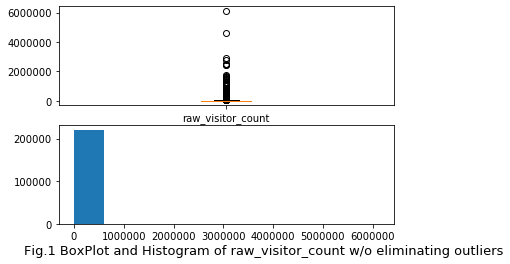

In [17]:
import matplotlib.pyplot as plt
#以属性raw_visitor_count为例，对离群点不做处理
to_visulize = 'raw_visitor_count'
data_vis = csv[to_visulize].dropna()#去除异常点

plt.subplot(211)
plt.boxplot(np.array(data_vis),labels=[to_visulize])
plt.subplot(212)
plt.hist(np.array(data_vis))
plt.text(-1000000, -70000, 'Fig.1 BoxPlot and Histogram of raw_visitor_count w/o eliminating outliers',fontsize=13)

可以看到由于离群点过多且分布过广，导致盒图和直方图都无法很好地展示出数据的分布细节。

Text(-500, -15000, 'Fig.2 BoxPlot and Histogram of raw_visitor_count w/ eliminating outliers')

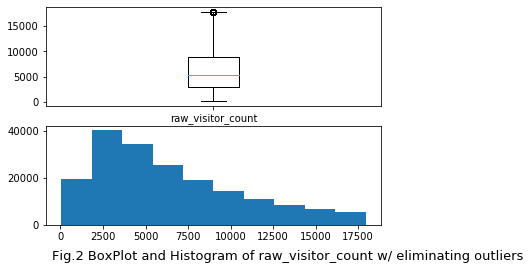

In [18]:
iqr = data_vis.describe()[-2] - data_vis.describe()[-4]
q1, q3 = data_vis.describe()[-2], data_vis.describe()[-4]
index = [i<(q3+1.5*iqr) and i>(q1-1.5*iqr) for i in np.array(data_vis)]#去除离群点
data_el = data_vis[index]
plt.subplot(211)
plt.boxplot(np.array(data_el),labels=[to_visulize])
plt.subplot(212)
plt.hist(np.array(data_el))
plt.text(-500, -15000, 'Fig.2 BoxPlot and Histogram of raw_visitor_count w/ eliminating outliers',fontsize=13)

可以看到，在去除离群点后，盒图和直方图很好地展示了该属性的分布。

# 2. 数据缺失的处理
仍选择属性raw_visitor_count为例
## 2.1 观察数据集中缺失数据
通过对NULL样本的观察，raw_visitor_count与raw_visit_count和distance_from_home常常同时出现，推测可能是由于相应的设置下没有访客或是记录出错。

## 2.2 将缺失部分剔除
在1.2中的预处理方法即是将缺失部分剔除，不再赘述。
## 2.3 用最高频率值来填补缺失值

mode 2292.0


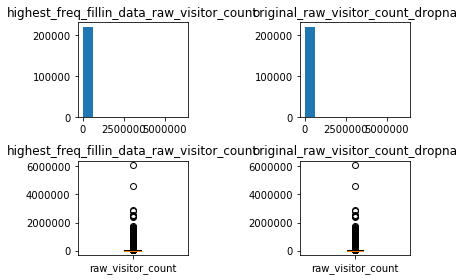

In [168]:
to_fill = 'raw_visitor_count'
mode = csv[to_fill].mode()[0]
print('mode', mode)
new_data = csv[to_fill].fillna(mode)
ind_n = eliminate_outliers(new_data)

old_data = csv[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.hist(new_data)
plt.title('highest_freq_fillin_data_raw_visitor_count')
plt.subplot(222)
plt.hist(old_data)
plt.title('original_raw_visitor_count_dropna')
plt.subplot(223)
plt.boxplot(new_data, labels=[to_fill])
plt.title('highest_freq_fillin_data_raw_visitor_count')
plt.subplot(224)
plt.boxplot(old_data, labels=[to_fill])
plt.title('original_raw_visitor_count_dropna')
plt.tight_layout()

可以看到，原始数据离群点过多、分布过广，导致分布的高密度区域细节差异无法辨认。为解决这个问题，在下面将离群点去除再进行作图。

mode 2292.0


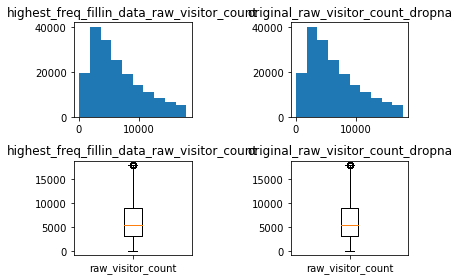

In [167]:
def eliminate_outliers(i):
    iqr = i.describe()[-2] - i.describe()[-4]
    q1, q3 = i.describe()[-2], i.describe()[-4]
    index = [_<(q3+1.5*iqr) and _>(q1-1.5*iqr) for _ in np.array(i)]#去除离群点
    return index
    
to_fill = 'raw_visitor_count'
mode = csv[to_fill].mode()[0]
print('mode', mode)
new_data = csv[to_fill].fillna(mode)
ind_n = eliminate_outliers(new_data)

old_data = csv[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.hist(new_data[ind_n])
plt.title('highest_freq_fillin_data_raw_visitor_count')
plt.subplot(222)
plt.hist(old_data[ind_o])
plt.title('original_raw_visitor_count_dropna')
plt.subplot(223)
plt.boxplot(new_data[ind_n], labels=[to_fill])
plt.title('highest_freq_fillin_data_raw_visitor_count')
plt.subplot(224)
plt.boxplot(old_data[ind_o], labels=[to_fill])
plt.title('original_raw_visitor_count_dropna')
plt.tight_layout()

由于缺失值占数据集规模大小的比例较小，所以仅能在直方图在模态位置附近观察到细微的增长。

## 2.4 通过属性的相关关系来填补缺失值
设想使用raw_visitor_count属性和distance_from_home属性回归raw_visit_count属性缺失值。
但是该数据集raw_visitor_count属性总和其他两个属性同时缺失，而其他数值属性如date_range_start和date_range_end总是不变的常数，标称属性census_block_group又是无意义且独一无二的编码(标称属性)。因此无法通过属性的相关关系来填补raw_visitor_count属性缺失值。
## 2.5 通过数据对象之间的相似性来填补缺失值
分析类似2.4，有属性缺失的样本的其他属性也为缺失或是无意义无法找到相似关系，通过数据对象之间的相似性来填补缺失值在这个数据集中不可能实现。

In [20]:
index = np.argwhere(np.array(csv['raw_visitor_count'].isna()))
index = [_[0] for _ in index]
csv['raw_visit_count'][index]

220629   NaN
220630   NaN
220631   NaN
220632   NaN
220633   NaN
          ..
220730   NaN
220731   NaN
220732   NaN
220733   NaN
220734   NaN
Name: raw_visit_count, Length: 106, dtype: float64

In [21]:
csv['distance_from_home'][index]

220629   NaN
220630   NaN
220631   NaN
220632   NaN
220633   NaN
          ..
220730   NaN
220731   NaN
220732   NaN
220733   NaN
220734   NaN
Name: distance_from_home, Length: 106, dtype: float64

# 二、Wine Reviews 数据集

In [76]:
csv2 = pd.read_csv('/kaggle/input/wine-reviews/winemag-data_first150k.csv')
csv3 = pd.read_csv('/kaggle/input/wine-reviews/winemag-data-130k-v2.csv')
csv2.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')

标称属性为：'country', 'description', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery'
       
数值属性为：'points','price'

In [23]:
nominal = ['country', 'description', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery']
numeric = ['points','price']

# 1. 数据可视化和摘要
## 1.1 数据摘要
* 标称数据

In [24]:
attr = 'country' #设置展示的属性
column = csv2[attr]
print(f'属性{attr}可能取值的频数:')
column.value_counts()

属性country可能取值的频数:


US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia                       14
Morocco                      12
England 

Text(0.5, 1.0, 'top10 values')

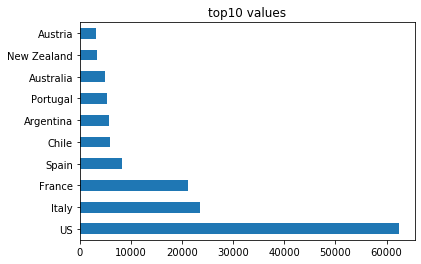

In [25]:
import matplotlib.pyplot as plt
#取前10高频数的取值展示为条形图
ax = column.value_counts().head(10).plot.barh()
plt.title('top10 values')

* 数值数据

In [26]:
column = csv2[numeric]
print(f'数值属性的五数概括:')
column.describe()[-5:]

数值属性的五数概括:


,points,price
min,80.0,4.0
25%,86.0,16.0
50%,88.0,24.0
75%,90.0,40.0
max,100.0,2300.0


In [27]:
print(f'数值属性的缺失值个数:')
print(column.isnull().sum())

数值属性的缺失值个数:
points        0
price     13695
dtype: int64


Text(82, -10000, 'Fig.1 BoxPlot and Histogram of points')

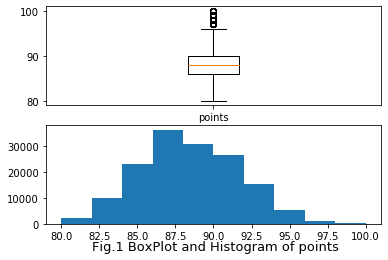

In [28]:
import matplotlib.pyplot as plt
#以属性points为例，对离群点不做处理
to_visulize = 'points'
data_vis = csv2[to_visulize].dropna()#去除异常点

plt.subplot(211)
plt.boxplot(np.array(data_vis),labels=[to_visulize])
plt.subplot(212)
plt.hist(np.array(data_vis))
plt.text(82, -10000, 'Fig.1 BoxPlot and Histogram of points',fontsize=13)

Text(82, -50000, 'Fig.1 BoxPlot and Histogram of price')

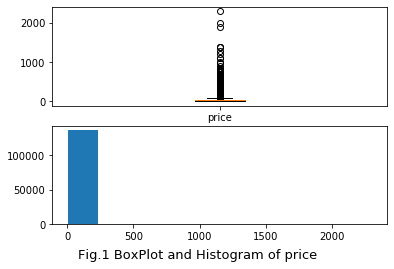

In [29]:
#以属性price为例，对离群点不做处理
to_visulize = 'price'
data_vis = csv2[to_visulize].dropna()#去除异常点

plt.subplot(211)
plt.boxplot(np.array(data_vis),labels=[to_visulize])
plt.subplot(212)
plt.hist(np.array(data_vis))
plt.text(82, -50000, 'Fig.1 BoxPlot and Histogram of price',fontsize=13)

可以看到points属性的展示效果较好，而price属性由于较多的离群点盒图、直方图展示效果很差，因此接下来进行离群点的消除后再次展示price属性。

Text(0, -7000, 'Fig.1 BoxPlot and Histogram of price w/ eliminating outliers')

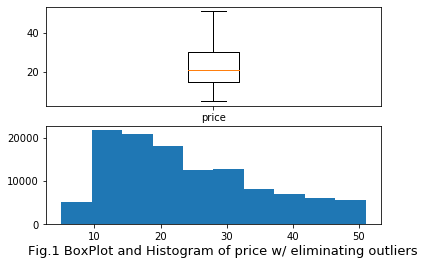

In [30]:
def eliminate_outliers(i):
    iqr = i.describe()[-2] - i.describe()[-4]
    q1, q3 = i.describe()[-2], i.describe()[-4]
    index = [_<(q3+1.5*iqr) and _>(q1-1.5*iqr) for _ in np.array(i)]#去除离群点
    return index

to_visulize = 'price'
data_vis = csv2[to_visulize].dropna()#去除异常点

ind = eliminate_outliers(data_vis)#去除离群点
plt.subplot(211)
plt.boxplot(np.array(data_vis[ind]),labels=[to_visulize])
plt.subplot(212)
plt.hist(np.array(data_vis[ind]))
plt.text(0, -7000, 'Fig.1 BoxPlot and Histogram of price w/ eliminating outliers',fontsize=13)

# 2. 数据缺失的处理
选择属性price为例,共缺失13695次。
## 2.1 观察数据集中缺失数据
通过对属性缺失样本的观察，没有发现price属性为NULL的直接规律，推测原因可能是记录出错。
## 2.2 将缺失部分剔除
在1.2中的预处理方法即是将缺失部分剔除，不再赘述。
## 2.3 用最高频率值来填补缺失值

mode 20.0


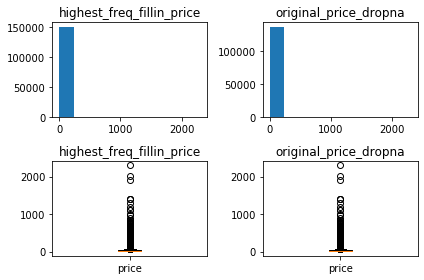

In [164]:
to_fill = 'price'
mode = csv2[to_fill].mode()[0]
print('mode', mode)
new_data = csv2[to_fill].fillna(mode)
ind_n = eliminate_outliers(new_data)

old_data = csv2[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.hist(new_data)
plt.title('highest_freq_fillin_price')
plt.subplot(222)
plt.hist(old_data)
plt.title('original_price_dropna')
plt.subplot(223)
plt.boxplot(new_data, labels=[to_fill])
plt.title('highest_freq_fillin_price')
plt.subplot(224)
plt.boxplot(old_data, labels=[to_fill])
plt.title('original_price_dropna')
plt.tight_layout()

可以看到，离群点过多、过远，导致分布的细节淹没了。

mode 20.0


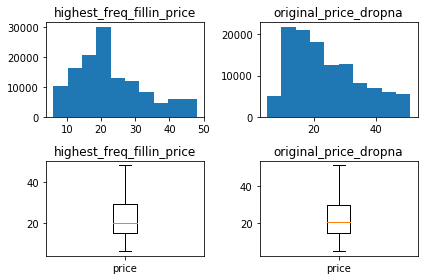

In [163]:
to_fill = 'price'
mode = csv2[to_fill].mode()[0]
print('mode', mode)
new_data = csv2[to_fill].fillna(mode)
ind_n = eliminate_outliers(new_data)

old_data = csv2[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.hist(new_data[ind_n])
plt.title('highest_freq_fillin_price')
plt.subplot(222)
plt.hist(old_data[ind_o])
plt.title('original_price_dropna')
plt.subplot(223)
plt.boxplot(new_data[ind_n], labels=[to_fill])
plt.title('highest_freq_fillin_price')
plt.subplot(224)
plt.boxplot(old_data[ind_o], labels=[to_fill])
plt.title('original_price_dropna')
plt.tight_layout()

在直方图中我们能观察到填充后明显的变化，数据在模态所在的20附近的取值明显增多。

## 2.4 通过属性的相关关系来填补缺失值
设想使用points属性回归price属性缺失值。

In [32]:
valid_ind = np.argwhere(np.array(csv2['price'].isna()) == False)
missing_ind = np.argwhere(np.array(csv2['price'].isna()) == True)
missing_ind = [_[0] for _ in missing_ind]
valid_ind = [_[0] for _ in valid_ind]
#print(valid_ind)
data = [[csv2['points'][i],csv2['price'][i]] for i in valid_ind]
#print(csv2['points'][0])
dataMat = np.array(data)
X = dataMat[:,0:1]   # 变量x
y = dataMat[:,1]   #变量y
X_pre = np.array([csv2['points'][i] for i in missing_ind])
X_pre = X_pre.reshape(-1, 1)

系数矩阵:
 [5.18468773]
线性回归模型:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


Text(0.5, 1.0, 'linear regression')

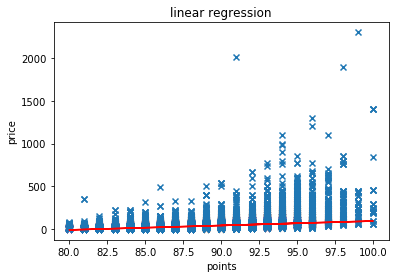

In [36]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
model.fit(X, y)   # 线性回归建模
print('系数矩阵:\n',model.coef_)
print('线性回归模型:\n',model)
predicted = model.predict(X_pre)
p = model.predict(X)
plt.scatter(X, y, marker='x')
plt.plot(X, p,c='r')
plt.xlabel("points")
plt.ylabel("price")
plt.title('linear regression')

从上图观察到，拟合并不理想，原因是points属性包含的信息量不足，然而在数据集中其他标称数据维度太高难以利用来进行线性回归，所以这个一元线性回归模型已经是较合理的回归模型了。

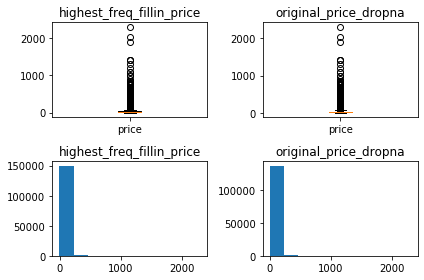

In [161]:
to_fill = 'price'
price = copy.deepcopy(csv2[to_fill])
points = csv2['points']
for i in missing_ind:
    price[i] = model.predict(np.array(points[i]).reshape(1,1))

new_data = price
#ind_n = eliminate_outliers(new_data)

old_data = csv2[to_fill].dropna()
#ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.boxplot(new_data, labels=[to_fill])
plt.title('highest_freq_fillin_price')
plt.subplot(222)
plt.boxplot(old_data, labels=[to_fill])
plt.title('original_price_dropna')
plt.subplot(223)
plt.hist(new_data)
plt.title('highest_freq_fillin_price')
plt.subplot(224)
plt.hist(old_data)
plt.title('original_price_dropna')
plt.tight_layout()

可以从上图看到，未经去除离群点的price属性，因为分布跨度太大而难以分辨分布之间的区别。

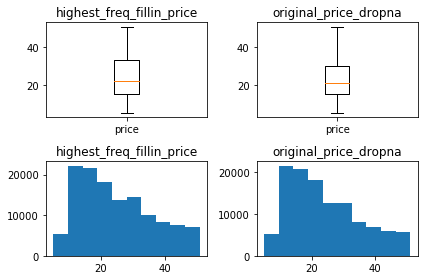

In [160]:
import copy
to_fill = 'price'
price = copy.deepcopy(csv2[to_fill])
points = csv2['points']
for i in missing_ind:
    price[i] = model.predict(np.array(points[i]).reshape(1,1))

new_data = price
ind_n = eliminate_outliers(new_data)

old_data = csv2[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.boxplot(new_data[ind_n], labels=[to_fill])
plt.title('highest_freq_fillin_price')
plt.subplot(222)
plt.boxplot(old_data[ind_o], labels=[to_fill])
plt.title('original_price_dropna')

old_data = csv2[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(223)
plt.hist(new_data[ind_n])
plt.title('highest_freq_fillin_price')
plt.subplot(224)
plt.hist(old_data[ind_o])
plt.title('original_price_dropna')
plt.tight_layout() 

在去除离群点后，可以看到使用回归后的price属性值填充缺失值，使得Q3和中位数有不同程度的增大。从直方图中可以看出位于大于20区域的price属性值明显增多。

## 2.5 通过数据对象之间的相似性来填补缺失值
通过对数据集各个属性的观察，选取维度较小（取值范围小）、信息量大（该属性值方差大）的三个标称属性'country'、'province'、'variety',以及数值属性'points'作为相似性度量的输入。
具体地，各个标称属性被表示为独热向量，数值属性被归一化至0到1的区间后与三个代表标称属性的独热向量串联起来组成一个样本的特征表示，样本之间的余弦相似度被视作样本之间的相似度。


In [138]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
def ret_onehot(attr):
    a = copy.deepcopy(csv2[attr])
    if a.isna().sum():
        a = a.fillna(a.mode()[0])
    #print(a.isna().sum())
    encoder = LabelEncoder()  
    cat = encoder.fit_transform(a.values)
    cat = np.array(cat)

    enc = OneHotEncoder()
    a=enc.fit_transform(cat.reshape(-1,1))
    a=a.toarray()
    return a

def cos_dist(x,y):
    return 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))


In [148]:
from tqdm import tqdm
to_fill = 'price'
price = copy.deepcopy(csv2[to_fill])
points = csv2['points']
points = points / points.describe()[-1] # 归一化
points = np.array(points).reshape(-1,1)
country = ret_onehot('country')
province = ret_onehot('province')
variety = ret_onehot('variety')

feature = np.concatenate([points,country,province,variety],axis=-1)

sample_rate = 0.005
leng = len(points)
for i in missing_ind:
    summ = 0
    for j in valid_ind[::int(1//sample_rate)]:
        S = cos_dist(feature[i], feature[j])
        summ += S*price[j]
    price[i] = summ/leng/sample_rate

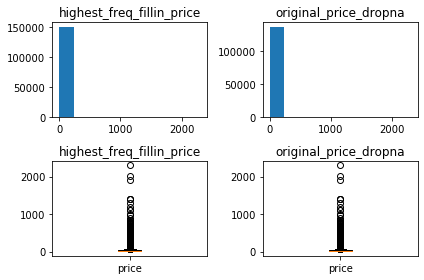

In [153]:
new_data = price
#ind_n = eliminate_outliers(new_data)

old_data = csv2[to_fill].dropna()
#ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.hist(new_data)
plt.title('highest_freq_fillin_price')
plt.subplot(222)
plt.hist(old_data)
plt.title('original_price_dropna')
plt.subplot(223)
plt.boxplot(new_data, labels=['price'])
plt.title('highest_freq_fillin_price')
plt.subplot(224)
plt.boxplot(old_data, labels=['price'])
plt.title('original_price_dropna')
plt.tight_layout() 

可以看到，在不做离群点剔除的情况下，无论是直方图还是盒图都难以解析数据集的细节，因此去除离群点后再分析是更好的选择，如下。

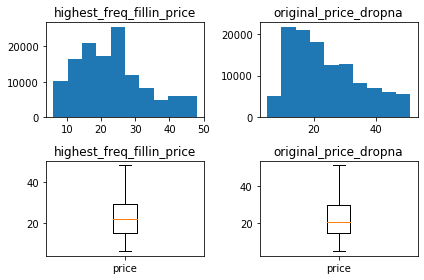

In [154]:
new_data = price
ind_n = eliminate_outliers(new_data)

old_data = csv2[to_fill].dropna()
ind_o = eliminate_outliers(old_data)
plt.subplot(221)
plt.hist(new_data[ind_n])
plt.title('highest_freq_fillin_price')
plt.subplot(222)
plt.hist(old_data[ind_o])
plt.title('original_price_dropna')
plt.subplot(223)
plt.boxplot(new_data[ind_n], labels=['price'])
plt.title('highest_freq_fillin_price')
plt.subplot(224)
plt.boxplot(old_data[ind_o], labels=['price'])
plt.title('original_price_dropna')
plt.tight_layout() 

上图为去除离群点后的盒图与直方图在填充price属性前后的对比。